# A Toy Problem - Enhanced Sampling

## Framing the Problem

Consider a system with two degrees of freedom with Hamiltonian:
$$
    H = \frac{px^2}{2m_x}\ + \frac{py^2}{2m_y}\ + \frac{D_0}{a^4}(x^2-a^2)^2 + \frac{1}{2}m_y\omega^2y^2 + \lambda xy
$$

We can see the potential energy is:
$$
   U(x, y) = \frac{D_0}{a^4}(x^2-a^2)^2 + \frac{1}{2}m_y\omega^2y^2 + \lambda xy 
$$

We want to calculate the marginal probability distribution function:
$$
    P(x) = \int dy e^{-\beta U(x, y)}
$$

So that we can ascertain the potential energy surface *A* of our system:
$$
    A(x) = -\frac{1}{\beta}lnP(x)

## Analytical Solution

To begin, I will calculate the marginal probability distribution analytically. This will serve as a benchmark value that I can compare to the results that I will simulate.

In [105]:
# Libraries
import numpy as np
import sympy as sp
import numdifftools as nd
import matplotlib.pyplot as plt
import random

In [141]:
# Constants
d = 5
a = 1
omega = 1
m_y = 1
lam = 2.878

# Function for the potential energy of the system
def potential_energy(x, y):
    '''
    Function to return the potential energy of system

    @param x : x coordinate
    @param y : y coordinate
    @return en : potential energy
    '''

    # Calculate energy
    en = (d * ((x ** 2) - (a ** 2)) ** 2) + (0.5 * m_y * (omega ** 2) * (y ** 2)) + (lam * x * y)

    # Return energy
    return en

With a function to calculate potential energy, I will integrate analytically with respect to y to obtain the marginal probability distribution *P(x)* and, consequently, the free energy surface *A(x)*. This will later be compared to the result obtained by am dynamics simulation. Note that I performed integration with Mathematica due to it's superior integration capabilities compared to python libraries like SymPy.

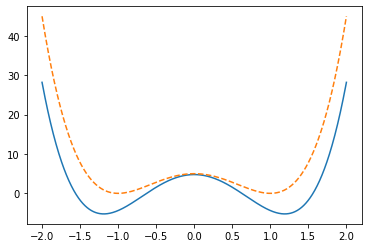

In [142]:
# Plotting Free Energy Surface
x = np.linspace(-2, 2, 1000)
fes = - np.log(1.25331 * np.exp(-((d * (a ** 2 - x ** 2) ** 2) / (a ** 4)) + ((0.5 * (x ** 2) * (lam ** 2)) / (m_y * (omega ** 2)))) / (np.sqrt(m_y) * omega)) / 1
pe = potential_energy(x, 0)
plt.plot(x, fes)
plt.plot(x, pe, linestyle='--')
plt.show()

## Choice of Integrator

Since I am using a Langevian Thermostat, I will be implementing the BAOAB integrator. This integrator has the following equations of motion:

$$
    p_{n+1/2} = p_n - \delta t \nabla U(x_n)/2:
$$
$$
    x_{n+1/2} = x_n + \delta t M^{-1} p_{n+1/2}/2;
$$
$$
    \hat{p}_{n+1/2} = c_1 p_{n+1/2} + c_3 M^{1/2} R_{n+1};
$$
$$
    x_{n+1} = x_{n+1/2} + \delta t M^{-1} \hat{p}_{n+1/2}/2;
$$
$$
    p_{n+1} = \hat{p}_{n+1/2} - \delta t \nabla U(x_{n+1})/2;
$$

Where:
$$
    c_1 = e^{-\gamma \delta t}, \quad c_2 = \gamma^{-1}(1-c_1), \quad c_3 = \sqrt{k_BT(1-c_1^2)}
$$

where, initially, I will set &gamma; to be 1

## Numerical Solution

### My algorithm

1. Initialize coordinate, choose v<sub>x</sub> and v<sub>y</sub>.
2. Compute forces $$F = -\nabla U(x, y)$$
3. Update position and momentum (BAOAB integrator, follows from Langevin Dynamics)
4. Update time $$ t = t + \Delta t$$
5. Repeat steps 2 through 4 for n timesteps.

A numerical solution requires simulating a particle in the x and y space we have constrained our system to. In order to do this we must initialize a system with x and y coordinates at time of 0 seconds. We also need to specify temperature and masses for x and y directions.

In [153]:
def wrapped_pe(params):
    '''
    Function to wrap the potential energy function into a format that numdifftools can take the gradient of

    @params params : the parameter list

    @return func : wrapped function
    '''

    # Save parameters
    x, y = params
    return potential_energy(x, y)

def run_simulation(n_steps, m_x, m_y, kt_x, kt_y):
    '''
    Function to run simulation for x timesteps

    @param n_steps : number of timesteps to take
    @param m_x : mass for x-coordinate
    @param t_x : temperature for x-coordinate
    @param m_y : mass for y-coordinate
    @param t_y : temperature for y_coordinate

    @return x_pos : x-coordinate data
    @return free_en : free energy at each x position
    '''

    # Lists for data collection 
    steps = []
    x_pos = []
    free_en = []

    # Step 1: Initialize system
    coords = [-1, 1]
    velocity = [random.gauss(0.1, 0.05), random.gauss(0.1, 0.05)]
    momenta = [m_x * velocity[0], m_y * velocity[1]]
    time, time_step = 0, 0.25 * (10 ** -3)

    # Simulation loop
    for i in range(n_steps):

        # Step 2: Compute forces
        gradient = -(nd.Gradient(wrapped_pe)(coords))

        # Step 3: Move coordinate
        coords[0], momenta[0] = integrate_EOM(coords[0], momenta[0], gradient[0], kt_x, time_step, m_x)  # EOM and thermostat for x
        coords[1], momenta[1] = integrate_EOM(coords[1], momenta[1], gradient[1], kt_y, time_step, m_y)  # EOM and thermostat for y

        # Step 4: Accelerate time
        time = time + time_step

        # Record values and repeat
        steps.append(i+1)
        x_pos.append(coords[0])

    # Return data
    return x_pos, steps

        

def integrate_EOM(position, momentum, grad, kt, time_step, mass):
    '''
    Function to update coordinates and momenta with BAOAB integrator

    @param positions : positions
    @param momenta : momenta
    @param grad : force gradient in one direction
    @param temperature : temperature
    @param time_step : time step size
    @param mass : mass of coordinate

    @return new_pos : new positions
    @return new_momenta : new momenta
    '''

    # Initialize constants
    c1 = np.exp(-1 * time_step)
    c3 = np.sqrt(kt * (1 - (c1 ** 2)))

    # Integrate EOM
    p_int = momentum - (time_step * grad) / 2
    position_int = position + (time_step * (mass ** -1) * p_int) / 2
    p_int = (c1 * p_int) + (c3 * (mass ** (1/2)) * random.normalvariate(0.5, 0.25))
    position_new = position_int + (time_step * (mass ** -1) * p_int) / 2
    p_new = p_int - (time_step * grad) / 2

    return position_new, p_new
    

## Simulation Testing

Below is code for testing the simulation written above and analyzing resulting data. Relevant figures like x position over time can be generated and used to visualize the movement of the particle and the free energy of the system.

In [154]:
# Run simulation for same and different mass/temperature
x1, steps_1 = run_simulation(10000, 300, 1, 10, 1)